In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
warnings.filterwarnings('ignore')

In [31]:
def similarity(h1, h2):
    """Compute similarity as Re(h1^T * conj(h2)) / D."""
    D = len(h1)
    return np.real(np.dot(h1.conj(), h2)) / D

def gen_basis(D, n, distribution, cov=None):

    if distribution=="gaussian":
        if cov is None:
            cov = np.eye(n)
        hp = np.random.multivariate_normal(mean=np.zeros(n), cov=cov, size=D)       
    elif distribution=="uniform":
        hp = np.random.uniform(0, 2 * np.pi, size=(D, n))
    elif distribution == "laplace":
        hp = np.random.laplace(0, 1, size=(D, n)) 
    elif distribution == "cauchy":
        hp = np.random.standard_cauchy(size=(D, n)) 
    else:
        raise ValueError("Unsupported distribution type")
    return hp 

def encode_feature(W, features, alpha=1.0):
    scaled_W = W * alpha
    if features.ndim == 1:
        dot_product = np.dot(scaled_W, features)
    elif features.ndim == 2:
        dot_product = np.dot(features, scaled_W.T)
    encoded = np.exp(1j * dot_product)
    return encoded

## **(a) Loading MNIST dataset from Pytorch**

In [32]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_data = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_data = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

## **(b) Normalizing and Spliting the Data**

In [33]:
train_data = train_data.reshape(train_data.shape[0], -1)
train_data = train_data / np.linalg.norm(train_data, axis=1, keepdims=True)
test_data = test_data.reshape(test_data.shape[0], -1)
test_data = test_data / np.linalg.norm(test_data, axis=1, keepdims=True)

from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)


print(f'Train Data : {train_data.shape}')
print(f'Train Labels : {train_labels.shape}')
print(f'Validation Data : {val_data.shape}')
print(f'Validation Labels : {val_labels.shape}')
print(f'Test Data : {test_data.shape}')
print(f'Test Labels : {test_labels.shape}')

Train Data : (48000, 784)
Train Labels : (48000,)
Validation Data : (12000, 784)
Validation Labels : (12000,)
Test Data : (10000, 784)
Test Labels : (10000,)


## **(c) Building Feature Encoder**

In [34]:
D = 1000
n = train_data.shape[1]

alpha = 1.0
cov_matrix = np.eye(n)*alpha

W = gen_basis(D, n, distribution="gaussian", cov=cov_matrix)

train_encoded = np.array([encode_feature(W,x) for x in train_data])
val_encoded = np.array([encode_feature(W,x) for x in val_data])
test_encoded = np.array([encode_feature(W,x) for x in test_data])

In [35]:
print(f'Train data encoded shape: {train_encoded.shape}')
print(f'Validation data encoded shape: {val_encoded.shape}')
print(f'Test data encoded shape: {test_encoded.shape}')

Train data encoded shape: (48000, 1000)
Validation data encoded shape: (12000, 1000)
Test data encoded shape: (10000, 1000)


## **(d) Single pass fit**

In [36]:
num_classes = np.unique(train_labels).size # 10 classes (0-9 digits)
 
class_hpv = np.zeros((num_classes, D), dtype=np.complex128)

for label in range(num_classes):
    class_hpv[label] = np.sum(train_encoded[train_labels == label], axis=0)

## **(e) Inference and performance evaluation**

In [37]:
def predict(x_encoded, class_hpv):
    similarities = np.array([similarity(x_encoded,C) for C in class_hpv])
    return np.argmax(similarities)

def plot_classification_heatmap(confusion_matrix, class_labels=range(0,10), title="Confusion Matrix"):
    """
    Plots a heatmap for a classification confusion matrix.

    Parameters:
    - confusion_matrix: 2D NumPy array (square) representing classification results.
    - class_labels: List of labels for classes (default: None).
    - title: Title of the heatmap plot (default: "Classification Heatmap").
    """
    plt.figure(figsize=(8, 6))  # Set figure size
    sns.heatmap(confusion_matrix, annot=True, fmt="", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

Accuracy over test data before training: 0.6506
Accuracy over validation data before training: 0.6389166666666667


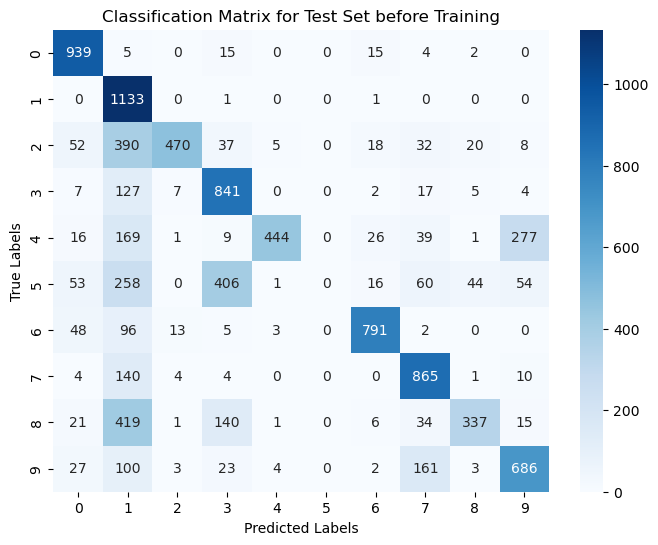

In [38]:
y_pred_test = []
y_pred_val = []

for i,(x_encoded,label) in enumerate(zip(test_encoded,test_labels)):
    prediction = predict(x_encoded,class_hpv)
    y_pred_test.append(prediction)

for i,(x_encoded,label) in enumerate(zip(val_encoded,val_labels)):
    prediction = predict(x_encoded,class_hpv)
    y_pred_val.append(prediction)

accuracy_test = accuracy_score(test_labels,y_pred_test)
conf_matrix = confusion_matrix(test_labels,y_pred_test)
accuracy_val = accuracy_score(val_labels,y_pred_val)

print(f'Accuracy over test data before training: {accuracy_test}')
print(f'Accuracy over validation data before training: {accuracy_val}')

plot_classification_heatmap(conf_matrix, title="Classification Matrix for Test Set before Training")


## **(f) Iterative Learning over dataset**

In [39]:
def single_pass(train_enc, labels, class_hpv):
    for i,(x_encoded,label) in enumerate(zip(train_enc,labels)):
        prediction = predict(x_encoded,class_hpv)
        if prediction!=label:
            class_hpv[label] += x_encoded
            class_hpv[prediction] -= x_encoded

def evaluate_accuracy(encoded_data, labels, class_hpv):
    preds = []
    for x_encoded, label in zip(encoded_data, labels):
        predicted_label = predict(x_encoded, class_hpv)
        preds.append(predicted_label)
    return accuracy_score(labels,preds)

In [40]:
EPOCHS = 30
min_epoch = 5
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(EPOCHS):

    single_pass(train_encoded,train_labels, class_hpv)

    train_acc = evaluate_accuracy(train_encoded,train_labels, class_hpv)
    val_acc = evaluate_accuracy(val_encoded,val_labels, class_hpv)
    test_acc = evaluate_accuracy(test_encoded,test_labels, class_hpv)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch + 1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Test Acc = {test_acc:.4f}")

    if epoch > min_epoch and val_accuracies[-1] < val_accuracies[-2]:
        break

Epoch 1: Train Acc = 0.8671, Val Acc = 0.8679, Test Acc = 0.8739
Epoch 2: Train Acc = 0.8845, Val Acc = 0.8840, Test Acc = 0.8868
Epoch 3: Train Acc = 0.8949, Val Acc = 0.8941, Test Acc = 0.8974
Epoch 4: Train Acc = 0.9022, Val Acc = 0.9021, Test Acc = 0.9058
Epoch 5: Train Acc = 0.9076, Val Acc = 0.9091, Test Acc = 0.9104
Epoch 6: Train Acc = 0.9127, Val Acc = 0.9127, Test Acc = 0.9143
Epoch 7: Train Acc = 0.9173, Val Acc = 0.9179, Test Acc = 0.9174
Epoch 8: Train Acc = 0.9211, Val Acc = 0.9212, Test Acc = 0.9205
Epoch 9: Train Acc = 0.9250, Val Acc = 0.9229, Test Acc = 0.9238
Epoch 10: Train Acc = 0.9278, Val Acc = 0.9249, Test Acc = 0.9264
Epoch 11: Train Acc = 0.9312, Val Acc = 0.9282, Test Acc = 0.9286
Epoch 12: Train Acc = 0.9334, Val Acc = 0.9303, Test Acc = 0.9298
Epoch 13: Train Acc = 0.9354, Val Acc = 0.9318, Test Acc = 0.9312
Epoch 14: Train Acc = 0.9378, Val Acc = 0.9333, Test Acc = 0.9327
Epoch 15: Train Acc = 0.9401, Val Acc = 0.9353, Test Acc = 0.9345
Epoch 16: Train Acc

## **(g) Model performance on the train, validation, and test sets per epoch**

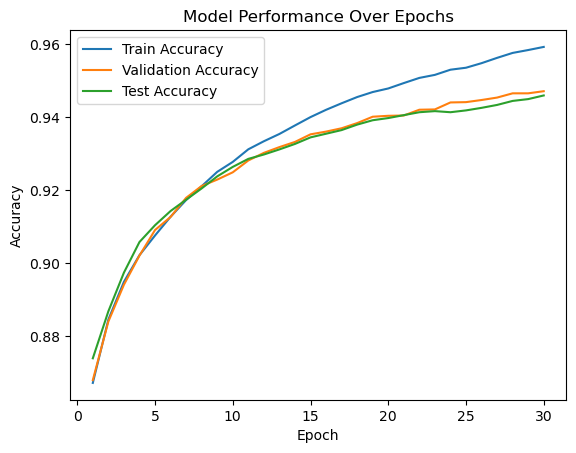

In [41]:
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Performance Over Epochs')
plt.legend()
plt.show()